In [1]:
import qiskit


In [2]:
try:
    from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
    from qiskit.circuit import Parameter
    print("Imports successful!")
except ImportError as e:
    print(f"ImportError: {e}")


Imports successful!


In [3]:

import numpy as np

np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1 - p0}

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam")]


def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc


qc = get_var_form(params)

In [5]:
from qiskit_aer.primitives import Sampler, Estimator

sampler = Sampler()


def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Simulate the circuit instance with paramters
    result = sampler.run(circuits=qc, parameter_values=params).result()
    # Get the quasi distribution for each measured state
    output_distr = result.quasi_dists[0]
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

In [6]:
import qiskit
print(qiskit.__version__)


0.46.2


In [7]:
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
import numpy as np

optimizer = COBYLA(maxiter=500, tol=0.0001)
# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
initial_point = np.random.rand(3)

result = optimizer.minimize(fun=objective_function, x0=initial_point)

# Obtain the output distribution using the final parameters
output_distr = (
    sampler.run(circuits=qc, parameter_values=result.x)
    .result()
    .quasi_dists[0]
)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))


Parameters Found: [1.22079289 0.7335981  1.93884374]
Target Distribution: {0: 0.308979188922057, 1: 0.691020811077943}
Obtained Distribution: {0: 0.33203125, 1: 0.66796875}
Cost: 0.042197872155885996


/tmp/ipykernel_2420059/2244171045.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA


linear entanglement:


/home/ketanm/miniconda3/envs/vqe_env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


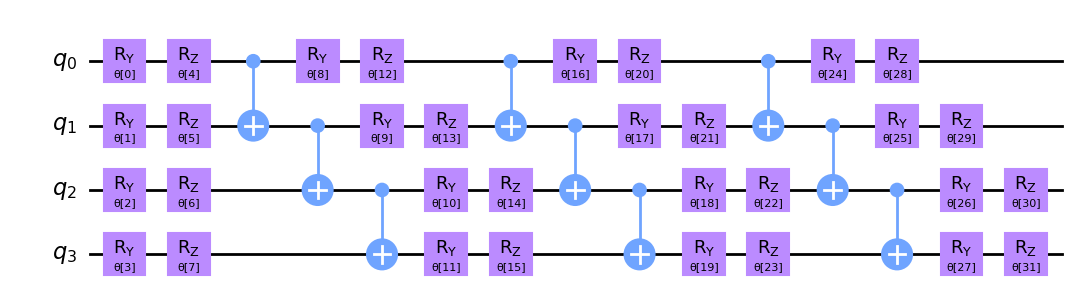

full entanglement:


/home/ketanm/miniconda3/envs/vqe_env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


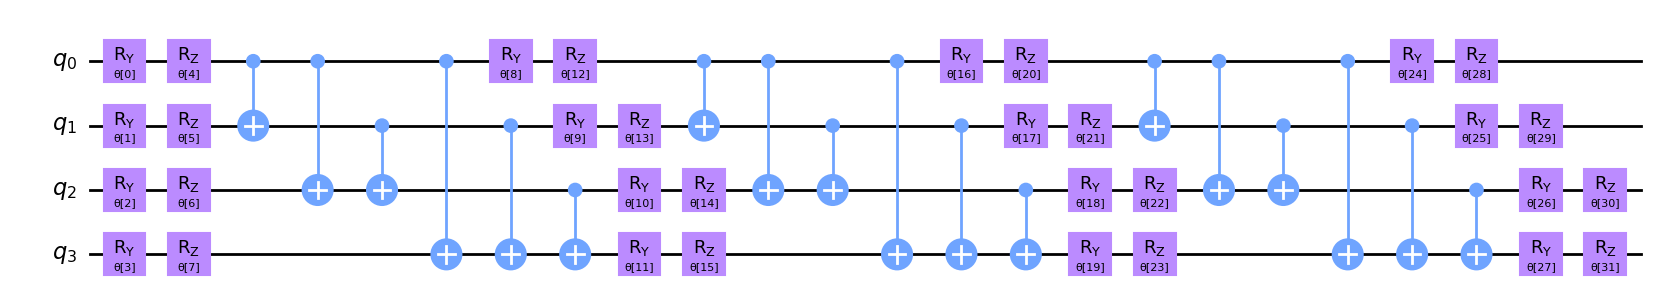

In [8]:
from qiskit.circuit.library import EfficientSU2

entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw("mpl", fold=-1))

In [2]:
# import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
# qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit_aer.primitives import Estimator




In [3]:



def get_qubit_op(dist):
   
    # N-H bond length in Angstroms
    dist_NH = 1.012
    # H-N-H bond angle in degrees
    angle_HNH = 107.8

    # Calculate the coordinates
    import math
    angle_rad = math.radians(angle_HNH / 2)
    x_H2 = -dist_NH * math.cos(angle_rad)
    y_H2 = dist_NH * math.sin(angle_rad)
    x_H3 = -dist_NH * math.cos(angle_rad)
    y_H3 = -dist_NH * math.sin(angle_rad)

    # Coordinates in Angstrom for NH3
    molecule = MoleculeInfo(
        symbols=["N", "H", "H", "H"],
        coords=[
            [0.0, 0.0, 0.0],  # Nitrogen
            [dist_NH, 0.0, 0.0],  # Hydrogen 1
            [x_H2, y_H2, 0.0],  # Hydrogen 2
            [x_H3, y_H3, 0.0]  # Hydrogen 3
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [4]:
from qiskit_aer import *
from qiskit_aer import Aer

try:
    simulator_gpu = Aer.get_backend('aer_simulator_extended_stabilizer')
    simulator_gpu.set_options(device='GPU')
    simulator_gpu.set_options(cuStateVec_enable=False)
    print("GPU options set successfully." , simulator_gpu)
except Exception as e:
    print(f"Failed to set GPU options: {e}")

GPU options set successfully. aer_simulator_extended_stabilizer_gpu


In [11]:
from qiskit.algorithms.optimizers import SLSQP , SPSA
import time
import numpy as np

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


start_time = time.time()
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
backend = Aer.get_backend('statevector_simulator')
noiseless_estimator = Estimator(approximation=True)




for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")
end_time = time.time()
execution_time1 = end_time - start_time
print(f"Execution time: {execution_time1} seconds")

Interatomic Distance: 0.5 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 0.7 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 0.9 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 1.1 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 1.3 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 1.5 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 1.7 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 1.9 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 2.1 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 2.3 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 2.5 VQE Result: -55.49234 Exact Energy: -55.49268
Interatomic Distance: 2.7 VQE Result: -55.49234 Exact Energy: -55.49268


: 

In [5]:
from qiskit_aer.primitives import Estimator
#qiskit_nature.settings.use_pauli_sum_op = False 
from qiskit.algorithms.optimizers import SLSQP , SPSA
from qiskit_aer import *
from qiskit_aer import Aer
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time
import ray
import os
import sys
from qiskit.primitives import BackendEstimator
 
 

start_time = time.time()
ray.shutdown()
ray.init(num_cpus=20, num_gpus=1)

distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
times = []
pids = []
cpu_name = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
# estimator = BackendEstimator(simulator_gpu)

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


@ray.remote
def compute_energy(dist):
        pid = os.getpid()
        p = psutil.Process(pid)
        affinity = p.cpu_num()
        qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)
        start = time.time()
        result = exact_solver(qubit_op, problem)
        exact_energy = result.total_energies[0].real   
        init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)

        var_form = UCCSD(
            num_spatial_orbitals, num_particles, mapper, initial_state=init_state
        )
    
        vqe = VQE(
            noiseless_estimator,
            # estimator,
            var_form,
            optimizer,
            initial_point=[0] * var_form.num_parameters,
            
        )

        vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result = problem.interpret(vqe_calc).total_energies[0].real
        end = time.time()
        computation_time = end - start
        return dist , exact_energy, vqe_result , computation_time , pid , affinity

results = [compute_energy.remote(dist) for dist in distances]


for result in ray.get(results):
   
    dist, exact_energy, vqe_result , computation_time , pid , affinity   = result
    exact_energies.append(exact_energy)
    vqe_energies.append(vqe_result)
    times.append(computation_time)
    pids.append(pid)
    cpu_name.append(affinity)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energy:.5f}",
          f"ComputationTime: {computation_time:.5f} sec "
          f"PID NO = : {pid} "
          f"CPU Number: {affinity} "
          
          
          )
          
print("All energies have been calculated")
end_time = time.time()
execution_time2 = end_time - start_time
print(f"Execution time: {execution_time2} seconds")

ray.shutdown()


2024-07-19 12:56:25,220	INFO worker.py:1779 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Interatomic Distance: 0.5 VQE Result: -55.49234 Exact Energy: -55.49268 ComputationTime: 634.62648 sec PID NO = : 978242 CPU Number: 23 
Interatomic Distance: 0.7 VQE Result: -55.49234 Exact Energy: -55.49268 ComputationTime: 627.87427 sec PID NO = : 978246 CPU Number: 28 
Interatomic Distance: 0.9 VQE Result: -55.49234 Exact Energy: -55.49268 ComputationTime: 615.07690 sec PID NO = : 978245 CPU Number: 5 
Interatomic Distance: 1.1 VQE Result: -55.49234 Exact Energy: -55.49268 ComputationTime: 626.36401 sec PID NO = : 978257 CPU Number: 44 
Interatomic Distance: 1.3 VQE Result: -55.49234 Exact Energy: -55.49268 ComputationTime: 611.91820 sec PID NO = : 978241 CPU Number: 21 
Interatomic Distance: 1.5 VQE Result: -55.49234 Exact Energy: -55.49268 ComputationTime: 615.63048 sec PID NO = : 978253 CPU Number: 15 
Interatomic Distance: 1.7 VQE Result: -55.49234 Exact Energy: -55.49268 ComputationTime: 615.51922 sec PID NO = : 978237 CPU Number: 22 
Interatomic Distance: 1.9 VQE Result: -55.

In [32]:
speedup = execution_time1/execution_time2
print(f"total speed up {speedup}x" )

total speed up 7.208646980418759x


In [8]:

# plt.figure(figsize=(10, 6))
# plt.plot(distances, times, marker='o', linestyle='-', color='b')
# plt.title('Distance vs Computation Time')
# plt.xlabel('Interatomic Distance (Angstrom)')
# plt.ylabel('Computation Time (seconds)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


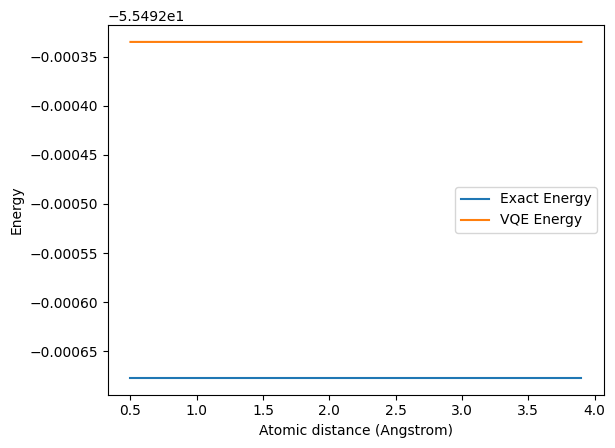

In [6]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

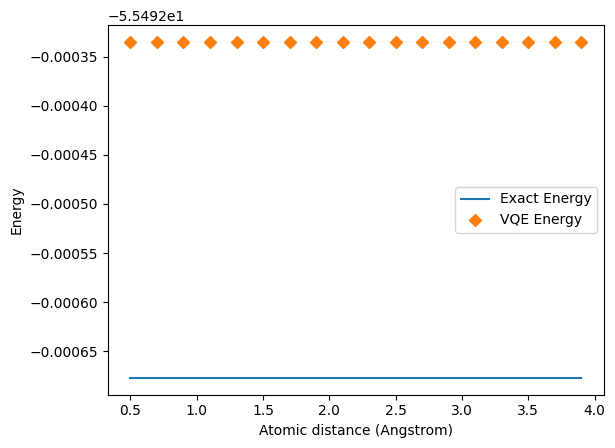

In [7]:
# import matplotlib.pyplot as plt

# plt.scatter(list1, vqe_energies, s = 40, label='Data Points', color='blue', )
# plt.scatter(list1, exact_energies,   color='green',)
# plt.legend()
# plt.show()

plt.plot(distances, exact_energies, label="Exact Energy" , ls = '-' , linewidth=1.5)
plt.plot(distances, vqe_energies, label="VQE Energy", ls = ':',marker= 'D', linewidth = '0.2')  #ls = '--', linewidth = '01.5'
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [8]:
molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)
problem = driver.run()

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)  # Set Mapper

hamiltonian = second_q_ops[0]  # Set Hamiltonian

# Do two qubit reduction
qubit_op = mapper.map(hamiltonian)

In [9]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored
# in Qiskit Terra, and are useful for extracting realistic noise models.

device = FakeVigo()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = Estimator(
    backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
)

/tmp/ipykernel_975458/464549336.py:7: DeprecationWarning: All fake backend instances based on real device snapshots (`FakeVigo`,`FakeSherbrooke`,...) have been migrated to the `qiskit_ibm_runtime` package. These classes are deprecated as of qiskit 0.46.0 and will be removed in qiskit 1.0.0. To migrate your code, run `pip install qiskit-ibm-runtime` and use `from qiskit_ibm_runtime.fake_provider import FakeExample` instead of `from qiskit.providers.fake_provider import FakeExample`. If you are using a custom fake backend implementation, you don't need to take any action.
  device = FakeVigo()


In [10]:
result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(noisy_estimator, var_form, optimizer)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: [-1.05914568]
